## Objective
Given the price, volume patterns classify next day trend

In [1]:
import pandas as pd
import json
import requests
import pandas as pd
from datetime import datetime, timedelta

In [2]:
! ls data

BTC-Daily.csv
BTCUSD_Candlestick_1_Hour_BID_01.01.2020-31.08.2024.csv
archive


### Download data

In [3]:
def fetch_bitstamp_ohlc(pair='btcusd', step=86400, start_date='2018-01-01', end_date='2024-11-05'):
    """
    Fetches historical OHLC data from Bitstamp.

    Parameters:
    - pair (str): Currency pair (default is 'btcusd').
    - step (int): Time interval in seconds (default is 86400 for daily data).
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - DataFrame: Pandas DataFrame containing the OHLC data.
    
    """
    base_url = 'https://www.bitstamp.net/api/v2/ohlc/'
    url = f"{base_url}{pair}/"

    # Convert dates to Unix timestamps
    start_timestamp = int(datetime.strptime(start_date, '%Y-%m-%d').timestamp())
    end_timestamp = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())

    params = {
        'step': step,
        'start': start_timestamp,
        'end': end_timestamp,
        'limit': 1000  # Maximum number of data points per request
    }

    all_data = []

    while start_timestamp < end_timestamp:
        response = requests.get(url, params=params)
        data = response.json()

        if 'data' in data and 'ohlc' in data['data']:
            ohlc_data = data['data']['ohlc']
            if not ohlc_data:
                break

            all_data.extend(ohlc_data)

            # Update start_timestamp to the timestamp of the last fetched data point
            last_timestamp = int(ohlc_data[-1]['timestamp'])
            start_timestamp = last_timestamp + step
            params['start'] = start_timestamp
        else:
            break

    # Convert to DataFrame
    df = pd.DataFrame(all_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df.set_index('timestamp', inplace=True)
    df = df.astype(float)

    return df
btc_2022_present = fetch_bitstamp_ohlc()
btc_2022_present = btc_2022_present.reset_index().rename(columns={'timestamp': 'date'})
btc_2022_present['date'] = pd.to_datetime(btc_2022_present['date'])
btc_2022_present = btc_2022_present.sort_values(by='date')
btc_2022_present.head()

,date,open,high,low,close,volume
0,2022-02-10,44426.24,45850.00,43209.07,43524.60,2692.623398
1,2022-02-11,43540.15,43969.72,41983.12,42406.19,2170.372397
2,2022-02-12,42392.22,43034.00,41740.06,42241.11,892.345330
3,2022-02-13,42232.68,42779.60,41882.54,42077.74,515.455742
4,2022-02-14,42078.53,42871.68,41575.00,42540.30,1270.886517


In [4]:
btc_2014_2022 = pd.read_csv('data/BTC-Daily.csv').sort_values(by='date')
btc_2014_2022.rename(columns={'Volume BTC':'volume'},inplace=True)
btc_2014_2022.drop(['unix','symbol','Volume USD'], axis=1, inplace=True)
btc_2014_2022['date'] = pd.to_datetime(btc_2014_2022['date'])
btc_2014_2022.tail()

,date,open,high,low,close,volume
4,2022-02-25,38360.93,39727.97,38027.61,39231.64,2202.851827
3,2022-02-26,39242.64,40330.99,38600.00,39146.66,912.724087
2,2022-02-27,39146.66,39886.92,37015.74,37712.68,1701.817043
1,2022-02-28,37717.10,44256.08,37468.99,43178.98,3160.618070
0,2022-03-01,43221.71,43626.49,43185.48,43185.48,49.006289


In [29]:
# Concatenate the two DataFrames
btc_df = pd.concat([btc_2014_2022, btc_2022_present], ignore_index=True)

# Drop duplicate dates, keeping the first occurrence
btc_df = btc_df.drop_duplicates(subset='date').reset_index(drop=True)

# Filter for dates from 2018 onward
btc_df = btc_df[btc_df['date'] >= pd.Timestamp('2019-01-01')].reset_index(drop=True)
btc_df.to_csv("data/btc_201901_202411.csv")

btc_df['avg_price_day'] = (btc_df['open']+btc_df['high']+btc_df['low']+btc_df['close'])/4
btc_df['volume_usd'] = btc_df['volume'] * btc_df['avg_price_day']
btc_df.drop(['volume','avg_price_day'], axis=1, inplace=True)


btc_df['open_pct'] = btc_df['close'].shift(1).combine(btc_df['open'], lambda prev_close, open_: ((open_ - prev_close) / prev_close) * 100 if pd.notnull(prev_close) else None)

# Calculate returns for 'high', 'low', and 'close' as a percentage change from the current 'open'
btc_df['high'] = ((btc_df['high'] - btc_df['open']) / btc_df['open']) * 100
btc_df['low'] = ((btc_df['low'] - btc_df['open']) / btc_df['open']) * 100
btc_df['close'] = ((btc_df['close'] - btc_df['open']) / btc_df['open']) * 100
btc_df['open'] = btc_df['open_pct']
btc_df.drop(['open_pct','open'], axis=1, inplace=True)

for i in range(1, 8):
    btc_df[f'close_{i}'] = btc_df['close'].shift(i)
    btc_df[f'volume_{i}'] = btc_df['volume_usd'].shift(i)

btc_df['close_tomorrow'] = btc_df['close'].shift(-1)
btc_df.dropna(inplace=True)

In [6]:
btc_df.head(2)

,date,high,low,close,volume_usd,close_1,volume_1,close_2,volume_2,close_3,volume_3,close_4,volume_4,close_5,volume_5,close_6,volume_6,close_7,volume_7,close_tomorrow
7,2019-01-08,2.671660,-1.754557,-0.252185,4.741774e+07,-0.872619,2.992960e+07,6.463911,2.116957e+07,-0.789116,1.396820e+07,0.847149,2.829185e+07,-2.633750,1.841022e+07,1.580484,2.130764e+07,3.508264,1.930125e+07,0.184742
8,2019-01-09,1.633394,-1.159272,0.184742,2.957036e+07,-0.252185,4.741774e+07,-0.872619,2.992960e+07,6.463911,2.116957e+07,-0.789116,1.396820e+07,0.847149,2.829185e+07,-2.633750,1.841022e+07,1.580484,2.130764e+07,-9.382252


In [7]:
btc_df.columns


Index(['date', 'high', 'low', 'close', 'volume_usd', 'close_1', 'volume_1',
       'close_2', 'volume_2', 'close_3', 'volume_3', 'close_4', 'volume_4',
       'close_5', 'volume_5', 'close_6', 'volume_6', 'close_7', 'volume_7',
       'close_tomorrow'],
      dtype='object')

In [8]:
btc_df.shape

(2128, 20)

<Axes: title={'center': 'Volume Over Time'}, xlabel='date', ylabel='volume'>

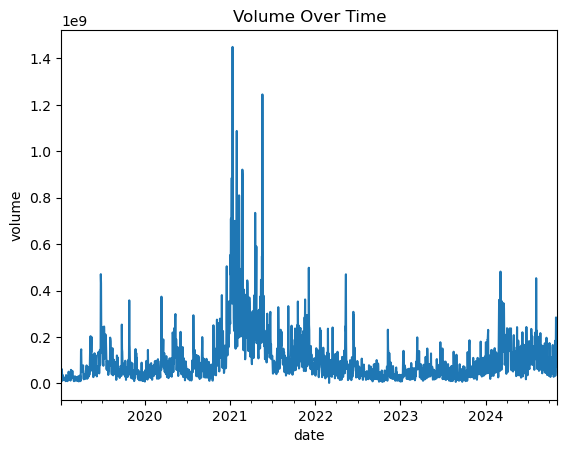

In [9]:
btc_df.set_index('date')['volume_usd'].plot(title='Volume Over Time', ylabel='volume', xlabel='date')

<Axes: title={'center': 'Volume Over Time'}, xlabel='date', ylabel='volume'>

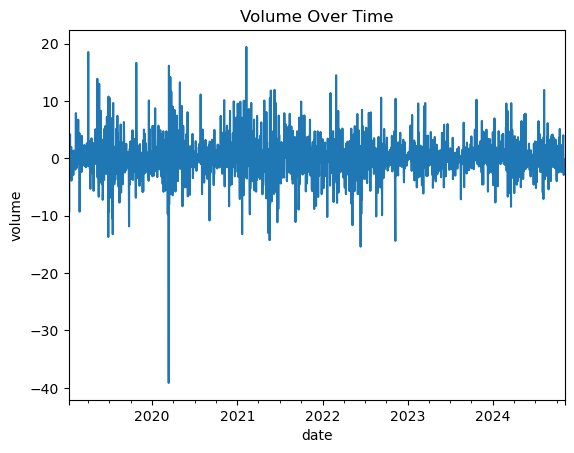

In [10]:
btc_df.set_index('date')['close'].plot(title='Volume Over Time', ylabel='volume', xlabel='date')

# Modelling

In [24]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, BayesianRidge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [25]:
def train_test_funk(btc_df):
    y = btc_df['close_tomorrow']

    X = btc_df[['high', 'low', 'close', 'volume_usd',
                'close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'close_6', 'close_7',
                'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5','volume_6', 'volume_7']]


    scaler = StandardScaler()
    for each_col in X.columns:
        if each_col[0] == 'v':
            X[each_col] = scaler.fit_transform(X[each_col].values.reshape(-1, 1))
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X, y, X_train, X_test, y_train, y_test
X, y, X_train, X_test, y_train, y_test = train_test_funk(btc_df)

/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_79628/3266112398.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[each_col] = scaler.fit_transform(X[each_col].values.reshape(-1, 1))
/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_79628/3266112398.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[each_col] = scaler.fit_transform(X[each_col].values.reshape(-1, 1))
/var/folders/5m/0jfggm0n5q39rqpgq1kr1wk00000gn/T/ipykernel_79628/3266112398.py:12: SettingWithCopyWarning: 
A valu

### vanilla ML models

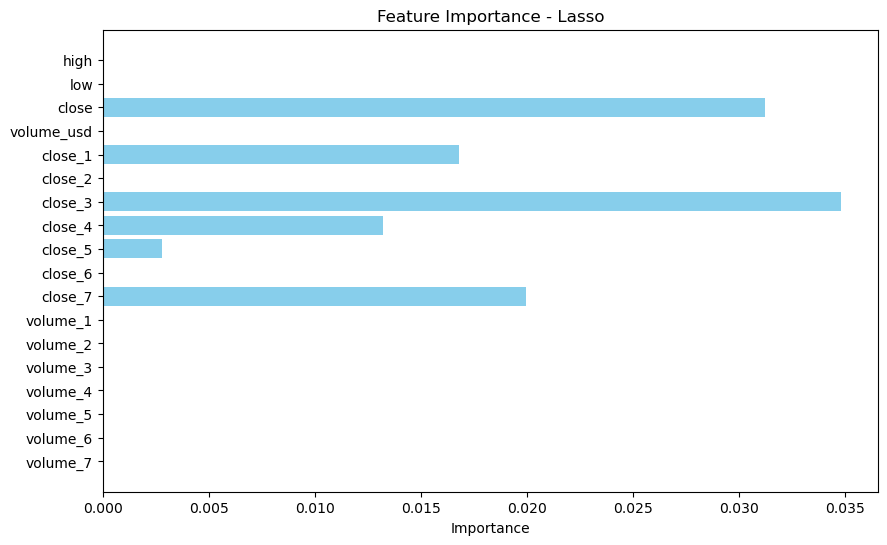

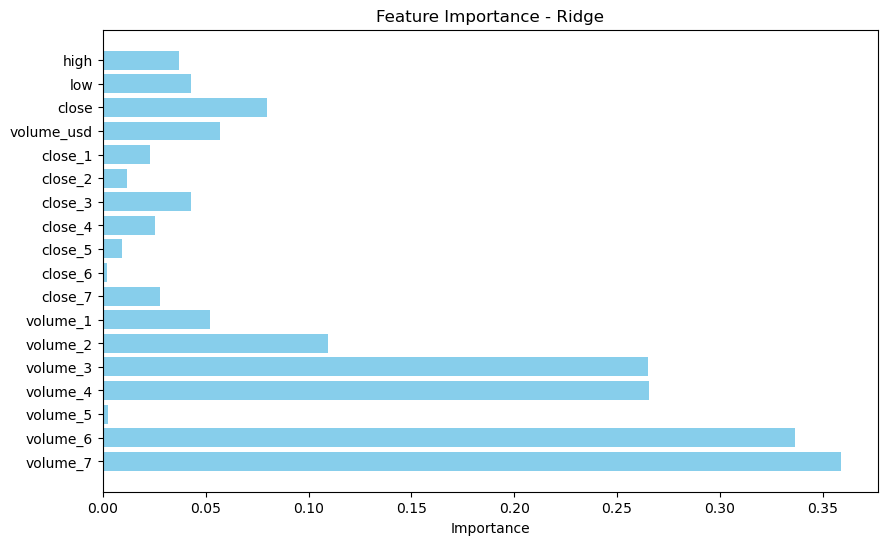

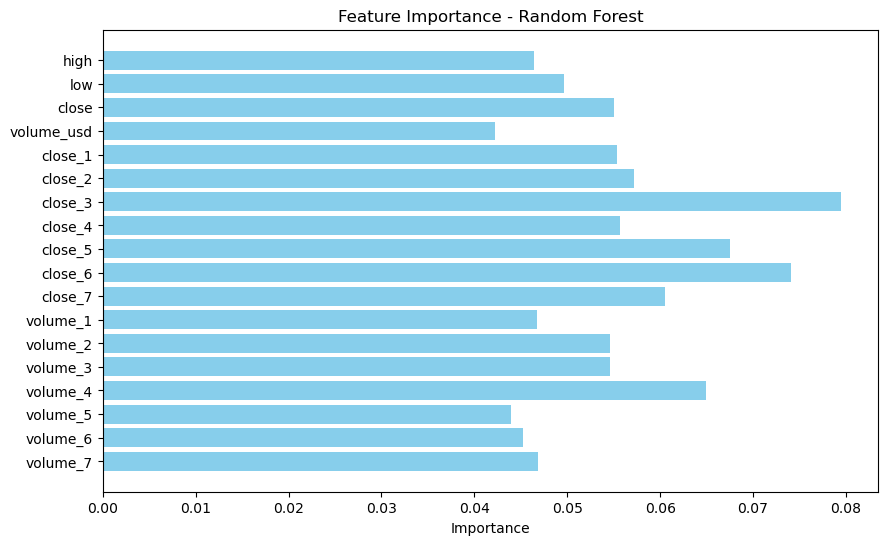

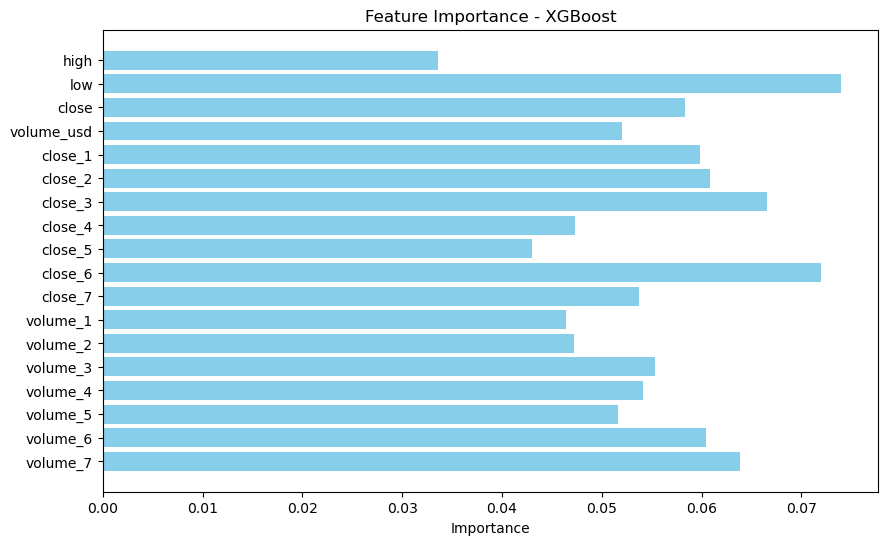

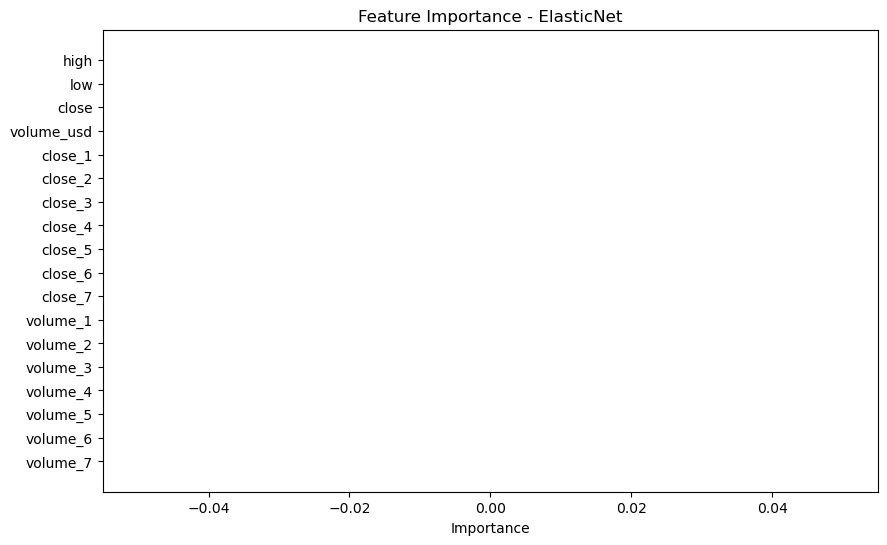

                  Model  Training MSE   Test MSE
0     Linear Regression     12.046654  11.223779
1                 Lasso     12.164638  11.268252
2                 Ridge     12.046654  11.223748
3         Random Forest      1.824528  12.359651
4               XGBoost      3.847561  12.802007
5            ElasticNet     12.224328  11.512276
6  SVR (SVM Regression)     11.155496  11.480150
7     Gradient Boosting      7.600575  11.675325
8   K-Nearest Neighbors      9.107949  13.311035
9        Bayesian Ridge     12.211371  11.472202


In [17]:


def vanillaMLModels(X_train,y_train,X_test,y_test,X):
    models = {
        "Linear Regression": LinearRegression(),
        "Lasso": Lasso(alpha=0.1),
        "Ridge": Ridge(alpha=0.2),
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(objective='reg:squarederror', alpha=1, max_depth=3, random_state=42),
        "ElasticNet": ElasticNet(alpha=1.0, l1_ratio=0.5),
        "SVR (SVM Regression)": SVR(kernel='rbf', C=1.0, epsilon=0.1),
        "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
        "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
        "Bayesian Ridge": BayesianRidge()
    }
    
    feature_names = X.columns.tolist()
    
    # Collect results
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        results.append([name, train_mse, test_mse])
        
        ##feature importance
        if name in ['Random Forest','XGBoost']:
            plt.figure(figsize=(10, 6))
            importances = model.feature_importances_
            plt.barh(feature_names, importances, color="skyblue")
            plt.xlabel("Importance")
            plt.title(f"Feature Importance - {name}")
            plt.gca().invert_yaxis()
            plt.show()
            
        if name in ['Lasso','Ridge','ElasticNet']:
            plt.figure(figsize=(10, 6))
            importances = np.abs(model.coef_)
            plt.barh(feature_names, importances, color="skyblue")
            plt.xlabel("Importance")
            plt.title(f"Feature Importance - {name}")
            plt.gca().invert_yaxis()
            plt.show()
        
            
        

    # Convert results to DataFrame for display
    results_df = pd.DataFrame(results, columns=["Model", "Training MSE", "Test MSE"])
    print(results_df)
    return 
vanillaMLModels(X_train,y_train,X_test,y_test,X)

### Vanilla DL Models

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Sample feature setup
# Assuming btc_df is your DataFrame with columns close_1, close_2, ..., volume_5, and target column 'close_tomorrow'
X = btc_df[['close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5']].values
y = btc_df['close_tomorrow'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define a bigger PyTorch model
class BiggerRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(BiggerRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize model, loss function, and optimizer
input_size = X_train.shape[1]
model = BiggerRegressionModel(input_size)
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    train_losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the training loss at each epoch
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Mean Squared Error: {test_loss.item():.4f}')

# Display final training losses for each epoch if needed
print("Training losses per epoch:", train_losses)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Assuming btc_df is your DataFrame with columns close_1, close_2, ..., volume_5, and target column 'close_tomorrow'
# Prepare features and target
X = btc_df[['close_1', 'close_2', 'close_3', 'close_4', 'close_5', 'volume_1', 'volume_2', 'volume_3', 'volume_4', 'volume_5']].values
y = btc_df['close_tomorrow'].values

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape X to be 3D for LSTM: (samples, time steps, features)
# Here, we assume each row is a single time step and features are treated as a sequence
X = X.reshape(X.shape[0], 5, 2)  # Assuming 5 timesteps and 2 features per timestep (e.g., close and volume)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Define an LSTM-based RNN model for regression
class RNNRegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(RNNRegressionModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        # LSTM layer
        _, (hn, _) = self.lstm(x)
        # Fully connected layer on the hidden state
        out = self.fc(hn[-1])
        return out

# Model parameters
input_size = 2         # Number of features per time step (e.g., close and volume)
hidden_size = 64       # Number of units in the LSTM hidden layer
num_layers = 2         # Number of LSTM layers

# Initialize model, loss function, and optimizer
model = RNNRegressionModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 100
train_losses = []

for epoch in range(epochs):
    model.train()
    
    # Forward pass
    predictions = model(X_train_tensor)
    loss = criterion(predictions, y_train_tensor)
    train_losses.append(loss.item())
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print the training loss at each epoch
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {loss.item():.4f}')

# Evaluate the model on test data
model.eval()
with torch.no_grad():
    test_predictions = model(X_test_tensor)
    test_loss = criterion(test_predictions, y_test_tensor)
    print(f'Test Mean Squared Error: {test_loss.item():.4f}')

# Display final training losses for each epoch if needed
print("Training losses per epoch:", train_losses)


In [28]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the Transformer model
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TransformerTimeSeries, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=512,
            dropout=0.1,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, output_dim)

    def forward(self, src, tgt):
        src = self.embedding(src)
        tgt = self.embedding(tgt)
        output = self.transformer(src, tgt)
        return self.fc_out(output)

# Model parameters
input_dim = X_train.shape[1]
d_model = 64
nhead = 4
num_layers = 2
output_dim = 1

# Initialize model, optimizer, and loss function
model = TransformerTimeSeries(input_dim, d_model, nhead, num_layers, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch.unsqueeze(1), X_batch.unsqueeze(1))
        loss = criterion(output.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Training MSE Loss: {train_loss:.4f}")

# Model evaluation on test set
model.eval()
with torch.no_grad():
    test_output = model(X_test_tensor.unsqueeze(1), X_test_tensor.unsqueeze(1))
    test_loss = criterion(test_output.squeeze(), y_test_tensor)
    print(f"Test MSE Loss: {test_loss.item():.4f}")

/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/50, Training MSE Loss: 12.4857
Epoch 2/50, Training MSE Loss: 12.3813
Epoch 3/50, Training MSE Loss: 12.2879
Epoch 4/50, Training MSE Loss: 12.2943
Epoch 5/50, Training MSE Loss: 12.1754
Epoch 6/50, Training MSE Loss: 12.4557
Epoch 7/50, Training MSE Loss: 12.1349
Epoch 8/50, Training MSE Loss: 12.3261
Epoch 9/50, Training MSE Loss: 12.1096
Epoch 10/50, Training MSE Loss: 12.3953
Epoch 11/50, Training MSE Loss: 12.3699
Epoch 12/50, Training MSE Loss: 12.3477
Epoch 13/50, Training MSE Loss: 12.4804
Epoch 14/50, Training MSE Loss: 12.0932
Epoch 15/50, Training MSE Loss: 12.1946
Epoch 16/50, Training MSE Loss: 12.1339
Epoch 17/50, Training MSE Loss: 12.1036
Epoch 18/50, Training MSE Loss: 12.2120
Epoch 19/50, Training MSE Loss: 12.1347
Epoch 20/50, Training MSE Loss: 12.1371
Epoch 21/50, Training MSE Loss: 12.2752
Epoch 22/50, Training MSE Loss: 12.3526
Epoch 23/50, Training MSE Loss: 12.0951
Epoch 24/50, Training MSE Loss: 12.1542
Epoch 25/50, Training MSE Loss: 12.1744
Epoch 26/

/Users/harshatamatam/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([426, 1])) that is different to the input size (torch.Size([426])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
